In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

import time
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2 
import itertools

import csv
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

import argparse
from data_loader_half_1 import get_loader
from data_loader_half_1 import get_dataset

import math
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import time
import shutil
import os
import torch.nn.functional as F

# Loading dataset

In [2]:
celeba_image_dir = '/home/name/celeba/stargan/data/celeba/images'
attr_path = '/home/name/celeba/stargan/data/celeba/list_attr_celeba.txt'
id_path = '/home/name/celeba/stargan/data/celeba/identity_CelebA.txt'
selected_attrs = ['Black_Hair']
celeba_crop_size = 224#178
image_size = 224 #128
batch_size = 40
num_workers = 0
mode1 = 'train' #test or train
mode2 = 'test'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") #"cuda:0" if torch.cuda.is_available() else 
torch.set_default_tensor_type('torch.cuda.FloatTensor')
 
print(device)

cuda:1


In [3]:
celeba_loader_train, data_train = get_loader(celeba_image_dir, attr_path, id_path, selected_attrs,celeba_crop_size, image_size, batch_size,'CelebA', mode1, num_workers)
celeba_loader_test, data_test = get_loader(celeba_image_dir, attr_path, id_path, selected_attrs,celeba_crop_size, image_size, batch_size,'CelebA', mode2, num_workers)

Finished preprocessing the CelebA dataset...
Finished preprocessing the CelebA dataset...


In [4]:
print(len(data_train))
print(len(data_test))

88374
12625


# Test images

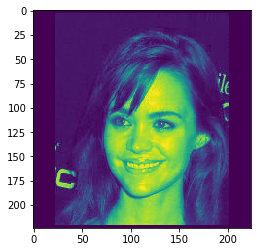

In [7]:
plt.figure()
plt.imshow(data_test[80][0][0])#model_syn.intermed.scales()[0].detach().numpy()
plt.show()

tensor([0., 0.], device='cpu')


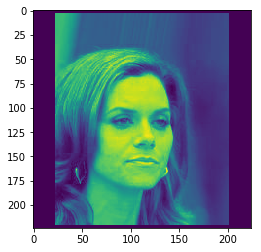

tensor([1., 1.], device='cpu')


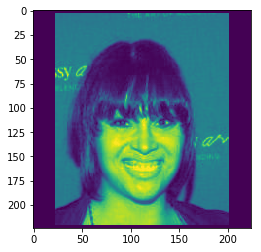

tensor([1., 1.], device='cpu')


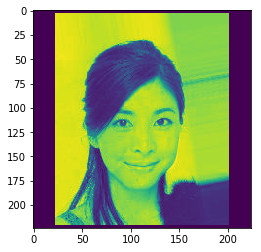

tensor([1., 1.], device='cpu')


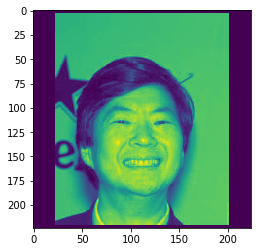

tensor([0., 0.], device='cpu')


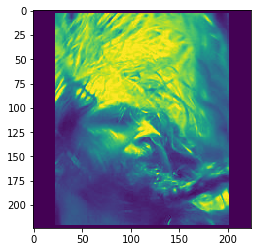

tensor([0., 0.], device='cpu')


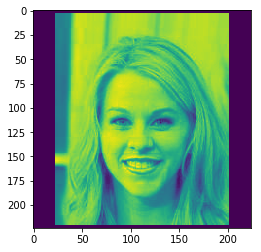

tensor([0., 0.], device='cpu')


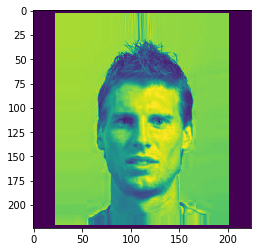

tensor([0., 0.], device='cpu')


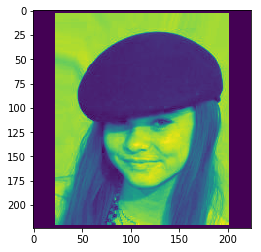

tensor([0., 0.], device='cpu')


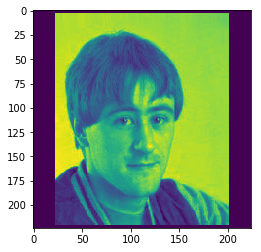

tensor([0., 0.], device='cpu')


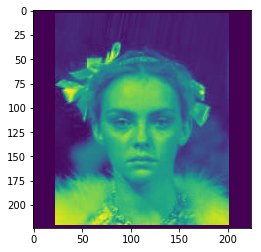

tensor([1., 1.], device='cpu')


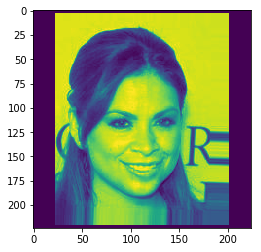

tensor([0., 0.], device='cpu')


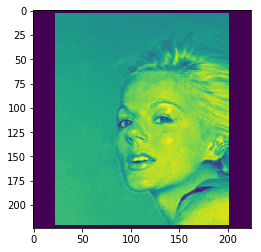

In [8]:
for i ,(im, labels) in enumerate(celeba_loader_test):
    print (labels[1])
    plt.figure()
    plt.imshow(im[1][0])#model_syn.intermed.scales()[0].detach().numpy()
    plt.show()
    if (i>10):
        break

In [9]:
#model = VGG_16_32()
#model = VGG_16_32()
#model = VGG_16_2()
resnet18 = models.resnet18(pretrained =True, num_classes=1000)
model = models.resnet18(num_classes=2)

In [10]:
#model_test = VGG_16_2()
#model_test.load_state_dict(torch.load("celeba-smiling-2-class-918",  map_location=device))
for key1,key2 in zip(model.state_dict().keys(), resnet18.state_dict().keys()):
    if('fc' in key1):
        break
    print(key1,key2)
    model.state_dict()[key2].copy_ ( resnet18.state_dict()[key1])



conv1.weight conv1.weight
bn1.weight bn1.weight
bn1.bias bn1.bias
bn1.running_mean bn1.running_mean
bn1.running_var bn1.running_var
bn1.num_batches_tracked bn1.num_batches_tracked
layer1.0.conv1.weight layer1.0.conv1.weight
layer1.0.bn1.weight layer1.0.bn1.weight
layer1.0.bn1.bias layer1.0.bn1.bias
layer1.0.bn1.running_mean layer1.0.bn1.running_mean
layer1.0.bn1.running_var layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight layer1.0.conv2.weight
layer1.0.bn2.weight layer1.0.bn2.weight
layer1.0.bn2.bias layer1.0.bn2.bias
layer1.0.bn2.running_mean layer1.0.bn2.running_mean
layer1.0.bn2.running_var layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight layer1.1.conv1.weight
layer1.1.bn1.weight layer1.1.bn1.weight
layer1.1.bn1.bias layer1.1.bn1.bias
layer1.1.bn1.running_mean layer1.1.bn1.running_mean
layer1.1.bn1.running_var layer1.1.bn1.running_var
layer1.1.bn1.num_batch

# Validate

In [13]:
def validate_single_label(model):
    model.to(device)
    model.eval()
    correct = 0
    size =0
    for im, labels in celeba_loader_test:
        im, labels = im.to(device), labels.to(device)
        labels = labels.long().squeeze(1)
        preds = model(im)
        values, indices = preds.max(-1)
        correct += indices.eq(labels).sum()

        del im
        del preds
        
        del values
        
        print("________")
        size += len(labels)
        del labels
        
    print(size)
    print(correct)
    print(float(correct)/float(size))

# Train

In [18]:
def train(model, criterion, optimizer):
    model.to(device)
    model.train()
    size = 0
    correcta = 0
    for i, (im, labels) in enumerate(celeba_loader_train):
        #if (i ==1):
         #   print (labels)
        im, labels = im.to(device), labels[:,0].to(device)
        print(labels.shape)
        labels = labels.long()
        optimizer.zero_grad()
        output = model(im)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        print (loss, "loss")
        #preds = model(im)
        values, indices = output.max(-1)
        size += len(labels)
        correcta += indices.eq(labels).sum()
        correct = indices.eq(labels).sum()
        del im
        del labels
        del output
        del values
        del indices
        
        print(correct, "correct out of 40")
    print(correcta, "correct out of all")
    print(size)
    print(float(correcta)/float(size))
    return correct, size
        #print(list(filter(lambda p: p.requires_grad, model.parameters()))[0][0])
        



In [19]:
criterion = nn.CrossEntropyLoss().to(device)#nn.NLLLoss().to(device) #95% 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.00002)

In [24]:
#lr=0.0001 ,#for test
#lr = 0.000001 3
lr =  0.0000001 #2
for epoch in range (2): # real
   
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=0)
    cor, size = train(model, criterion, optimizer)
    print (cor,size)
 
    #validate_single_label(model)
    
    #wd helps
    if (epoch>  5):
        lr  = 0.00001
        print(lr)

torch.Size([40])
tensor(0.1052, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1908, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3230, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2145, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3059, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1304, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3055, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2587, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.1722, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2559, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3069, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2749, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1932, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1568, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2118, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2021, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.2037, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2316, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1653, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2370, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.0918, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1736, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2090, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2255, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.1902, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1523, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2151, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2176, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3744, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3387, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(31, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1161, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1744, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.2355, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2466, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3516, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2326, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4431, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(31, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1506, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3902, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1630, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.3451, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2513, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1334, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2046, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1469, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1515, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1158, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3002, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.2147, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1741, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2709, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2597, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2468, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3918, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3906, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1111, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') co

torch.Size([40])
tensor(0.2499, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1702, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1692, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2301, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1923, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2239, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2099, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2488, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') co

torch.Size([40])
tensor(0.2052, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1314, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2457, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2743, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1427, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2159, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2045, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.0987, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') co

torch.Size([40])
tensor(0.1842, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1410, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2322, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2039, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1573, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3933, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1992, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2134, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.1238, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1807, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2884, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1566, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3205, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1443, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1882, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2713, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.3044, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3121, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2162, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1619, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2248, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2413, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4369, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2837, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.2038, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2108, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2716, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2384, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1749, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3559, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(31, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1903, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3875, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.1054, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2666, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1534, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2544, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.6044, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(29, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3107, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2348, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1722, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.1903, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2634, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1518, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1560, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2882, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1481, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1887, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3331, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') co

tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2714, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1321, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1636, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1860, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3180, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3054, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3732, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2598, device='cuda:1', grad_fn=<NllLoss

torch.Size([40])
tensor(0.2611, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.0914, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3976, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2579, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2142, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1883, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2368, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3179, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.2378, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2889, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2042, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2866, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2532, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3294, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3300, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1948, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.2568, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2978, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1832, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3595, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3039, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2479, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3163, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2774, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.3724, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2866, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2056, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3528, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2091, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3321, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2407, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2689, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.1665, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2717, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2027, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2040, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1344, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1939, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2303, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3524, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') co

torch.Size([40])
tensor(0.3247, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1535, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2076, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1498, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3067, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2718, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1857, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1234, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.1042, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.0945, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2227, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2264, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2210, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4311, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1358, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2025, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.3048, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4095, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3143, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1611, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3718, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2634, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2876, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2706, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.2164, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2242, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1887, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1864, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1937, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2568, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1897, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3871, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') co

torch.Size([40])
tensor(0.2680, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1741, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3006, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1028, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1402, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1983, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3579, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2327, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.2261, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1443, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2334, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1831, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1395, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.0720, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1237, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1613, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.1746, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1458, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.0864, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2734, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2376, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3693, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2197, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1346, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.2101, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2302, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2481, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1631, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2755, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2001, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2415, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1346, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.2144, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2067, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2580, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1988, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2240, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2255, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.0881, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1237, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.1380, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2187, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1373, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2144, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1416, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2323, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2095, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2381, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.1937, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1880, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1902, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2214, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2351, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3854, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2390, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1665, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.1587, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4981, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(29, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3153, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2054, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1540, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1821, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2360, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3519, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') co

torch.Size([40])
tensor(0.2943, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2713, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1474, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1514, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1999, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1996, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1689, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2429, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.1568, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2575, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2458, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2239, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1398, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1275, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1692, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1446, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.1463, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1639, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1626, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1430, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2148, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2453, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2343, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2391, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.2351, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4041, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2665, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3504, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1565, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3538, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1793, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3444, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') co

torch.Size([40])
tensor(0.1552, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2529, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2169, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2431, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3044, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2405, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1044, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2034, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.1336, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2153, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2068, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2308, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2566, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1497, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3370, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1242, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.2296, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1858, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3430, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1055, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3422, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3869, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(30, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2549, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1610, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.3772, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2372, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2231, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1146, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1425, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3951, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(30, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2225, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2035, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.2744, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2455, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2710, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1571, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3110, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3350, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1476, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1928, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.1857, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1094, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1724, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2303, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1727, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1559, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2089, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4576, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') co

torch.Size([40])
tensor(0.3969, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(31, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2172, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1814, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1993, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4007, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2953, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2633, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2488, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.2029, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2426, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3231, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2993, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3728, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3543, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2077, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3040, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.1982, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2792, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2179, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1455, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2238, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2642, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3118, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2024, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.3149, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2011, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1801, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2189, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2516, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2719, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1307, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2683, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.2452, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1836, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3419, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1649, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2959, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1536, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.4612, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(31, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1591, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.1821, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1523, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1431, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2218, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1576, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1392, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1393, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1497, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.2843, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1947, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1400, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1722, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2277, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3520, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3780, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2981, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.2065, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2177, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1604, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2651, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2199, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1907, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2997, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2697, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.3574, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2158, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1621, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3801, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(31, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3045, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1457, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1896, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3608, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.2210, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1897, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2347, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3236, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2032, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1555, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2196, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1690, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.1620, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2521, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2795, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2262, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2218, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2788, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1544, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1593, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.2354, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2034, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2102, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1734, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1435, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1659, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2534, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3356, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.2390, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1410, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2766, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2317, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1465, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2362, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2963, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1579, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.2823, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1955, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2244, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1914, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3105, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3118, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2323, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2020, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

torch.Size([40])
tensor(0.1991, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2246, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1293, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1673, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1301, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2270, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1634, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1621, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

tensor(0.1766, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1426, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1848, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1868, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3130, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1896, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2168, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1973, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
t

torch.Size([40])
tensor(0.2489, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3498, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2604, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2986, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1197, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3431, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3258, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3398, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.2137, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.5264, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1969, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3432, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1279, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(40, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3742, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2361, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2169, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.2278, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1680, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1875, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2379, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2033, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3966, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(32, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1647, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1838, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') co

torch.Size([40])
tensor(0.2316, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2556, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1741, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2079, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1040, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1274, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1462, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1248, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.3032, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2974, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2618, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1491, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1363, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2621, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1732, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2402, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.1964, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1933, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1858, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2233, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2188, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2158, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3863, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2636, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') co

torch.Size([40])
tensor(0.1862, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2652, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2698, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2164, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2196, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1611, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2556, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2820, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') co

torch.Size([40])
tensor(0.2811, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2170, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3051, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(34, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2347, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(35, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1044, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(39, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2506, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2481, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1862, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') co

torch.Size([40])
tensor(0.1476, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1514, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1885, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1530, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(37, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.1705, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(38, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3155, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.3325, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(33, device='cuda:1') correct out of 40
torch.Size([40])
tensor(0.2552, device='cuda:1', grad_fn=<NllLossBackward>) loss
tensor(36, device='cuda:1') co

In [11]:
validate_single_label(model) #90.60

________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
________
_